# Zonal Mean Analysis
This notebook applies the adiabatic theory for convectively set change in temperature to a range of latitudes.

It is adapted from the [theory breakdown.ipynb](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/theory_breakdown.ipynb) notebook used for Isca simulations.

In [1]:
import copy
import sys
import os

import warnings

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

#### Load in Data
Quantile data is obtained from CESM datasets and output into npz files. Here I am just interested in the npz files. For quantile data, the shape of array is `[2, n_lat, n_quant]` where the first index is `0` for land and `1` for ocean coordinates (quantiles are found separately at each latitude for land and ocean).

In [53]:
dir_npz = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/lat_quant'
exp_id = ['pre_industrial', 'co2_4x']
exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_4x_daily_output']
# exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_2x_daily_output']
# exp_names = ['isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=1', 'isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=2']
n_exp = len(exp_names)
ds_base = [np.load(os.path.join(dir_npz, f'{exp_id[i]}/npz_output/' + exp_names[i]+'.lat_quant_info_10years.npz')) for i in range(n_exp)]

if not np.all(ds_base[0]['quant']==ds_base[1]['quant']):
    raise ValueError('Quantiles change between datasets')

if not np.all(ds_base[0]['lat']==ds_base[1]['lat']):
    raise ValueError('Latitudes change between datasets')

if not np.all(ds_base[0]['surface']==ds_base[1]['surface']):
    raise ValueError('Surface change between datasets')

### Sanity check that npz and nd2 data looks similar
Should not be the same as *npz* data is for 10 years, but *nd2* data is for 30 years.

In [54]:
ds_nd2 = [xr.open_dataset(os.path.join(dir_npz, f'{exp_id[i]}/output.nd2')).load() for i in range(n_exp)]

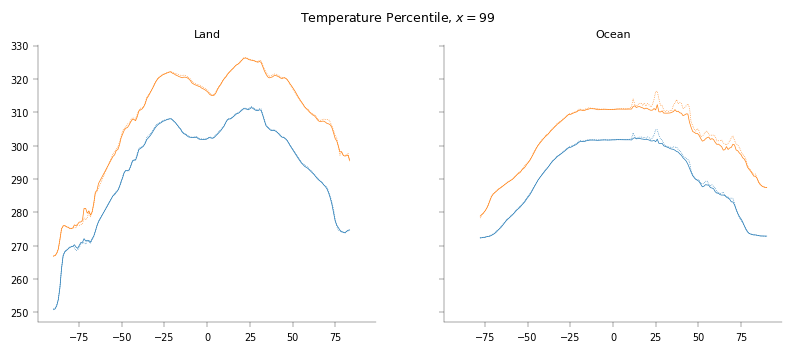

In [95]:
n_surf = ds_base[0]['surface'].size
quant_plot_ind = 2
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    ax[i].set_title(str(ds_nd2[0].surface[i].values).capitalize())
    for j in range(n_exp):
        use_ind = np.where(ds_base[0]['temp'][i, :, quant_plot_ind] > 0)
        ax[i].plot(ds_base[0]['lat'][use_ind], ds_base[j]['temp'][i, :, quant_plot_ind][use_ind], linestyle=':', color=default_colors[j])
        ax[i].plot(ds_base[0]['lat'][use_ind], ds_nd2[j]['T'].isel(lev=0, surface=i, quant=quant_plot_ind)[use_ind],
                   linestyle='-', color=default_colors[j])
fig.suptitle(f'Temperature Percentile, $x={ds_nd2[0].quant[quant_plot_ind]:.0f}$', fontsize=9)
plt.show()

In [4]:
# Create one dataset with all experiments with shape [n_surf, n_quant, n_exp, n_lat]
lat = ds_base[0]['lat']
n_lat = lat.size
n_quant = ds_base[0]['quant'].size
ds = {}     
for i in range(n_exp):
    for j in range(n_surf):
        no_surf_ind = np.where(ds_base[i]['n_grid_points'][j]==0)[0]
        for key in ds_base[i]:
            if ds_base[i][key].shape != (n_surf, n_lat, n_quant) or ds_base[i][key].dtype=='int':
                continue
            if key not in ds:
                ds[key] = np.zeros((n_surf, n_quant, n_exp, n_lat))
            ds[key][j, :, i] = ds_base[i][key][j].T
            ds[key][j, :, i, no_surf_ind] = np.nan      # Set to nan all latitudes where there is no coordinate of given surface

In [5]:
lat_ref_approx = 0.4
ind_lat_ref = np.argmin(np.abs(lat-lat_ref_approx))
lat_ref = lat[ind_lat_ref]
if 'pressure_surf_approx' in ds_base[0]:
    pressure_surf = float(ds_base[0]['pressure_surf_approx'])
    pressure_ft = float(ds_base[0]['pressure_ft_approx'])
else:
    pressure_surf = float(ds_base[0]['pressure_surf'])
    pressure_ft = float(ds_base[0]['pressure_ft'])

In [6]:
if 'rh' not in ds:
    warnings.warn('RH not in ds, so calculating from sphum')
    ds['rh'] = ds['sphum']/sphum_sat(ds['temp'], pressure_surf)
ds['cape_approx'] = np.zeros((n_surf, n_quant, n_exp, n_lat))
for i in range(n_surf):
    for j in range(n_quant):
        for k in range(n_exp):
            ds['cape_approx'][i, j, k] = get_cape_approx(ds['temp'][i, j, k], ds['rh'][i, j, k], pressure_surf, pressure_ft,
                                                         ds['temp_ft'][i, j, k], ds['mse_lapse'][i, j, k])[0]

/var/folders/7_/l8blmzys4m95r6r44gy_r4gh0000gn/T/ipykernel_79212/4249489855.py:2: UserWarning: RH not in ds, so calculating from sphum
  warnings.warn('RH not in ds, so calculating from sphum')


## Theory
Below I plot how well various versions of the theory do.

In [7]:
sf_simulated = (ds['temp'][:, :, 1] - ds['temp'][:, :, 0]) / (ds['temp'][:, :, 1] - ds['temp'][:, :, 0])[:, :,  ind_lat_ref, np.newaxis]
sf_simulated_error = np.sqrt((ds['temp_std'][:, :, 0]/(ds['temp'][:, :, 1] - ds['temp'][:, :, 0])[:, :,  ind_lat_ref:ind_lat_ref+1])**2 +
                             (ds['temp_std'][:, :, 1]/(ds['temp'][:, :, 1] - ds['temp'][:, :, 0])[:, :,  ind_lat_ref:ind_lat_ref+1])**2)
sf_theory = {key: np.zeros((n_surf, n_quant, n_lat)) for key in ['linear', 'non_linear']}
# gamma_ft = np.zeros((n_surf, n_quant))
sf_theory_breakdown = {key: np.zeros((n_surf, n_quant, n_lat)) for key in
                       ['temp_ft_change', 'r_change', 'temp_anom', 'r_anom', 'cape_change']}

sf_theory_approx = {key: np.zeros((n_surf, n_quant, n_lat)) for key in
                                  ['temp_ft_anom_change', 'temp_s_anom_change', 'r_change', 'temp_s_anom_r_change', 'anom_temp_s_r',
                                   'anom', 'ref_change', 'z_anom_change', 'nl', 'cape']}

for i in range(n_surf):
    for j in range(n_quant):
        for key in sf_theory:
            sf_theory[key][i, j], info_coef, _, info_cont = \
                get_scale_factor_theory(ds['temp'][i, j, :,  ind_lat_ref], ds['temp'][i, j], ds['rh'][i, j, :,  ind_lat_ref],
                                          ds['rh'][i, j], ds['temp_ft'][i, j], ds['mse_lapse'][i, j], pressure_surf, pressure_ft,
                                          include_non_linear='non_linear' in key, cape_form=True)
            if key == 'linear':
                # Only record breakdown for linear case as easier to interpret
                for key2 in sf_theory_breakdown:
                    sf_theory_breakdown[key2][i, j] = info_cont[key2]
        var = get_approx_terms(ds['temp'][i, j, :,  ind_lat_ref], ds['temp'][i, j], ds['rh'][i, j, :,  ind_lat_ref],
                               ds['rh'][i, j], ds['temp_ft'][i, j], ds['mse_lapse'][i, j], pressure_surf, pressure_ft, cape_form=True)[0]
        for key2 in sf_theory_approx:
            sf_theory_approx[key2][i, j] = var[key2]

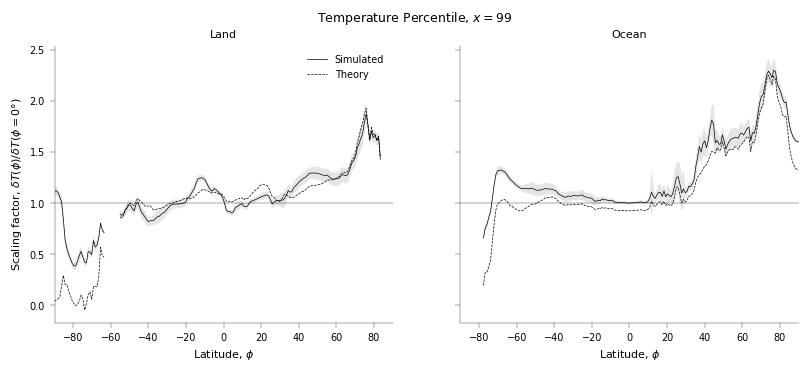

In [18]:
q_plot = 99     # decide which quantile to plot
q_plot_ind = np.where(ds_base[0]['quant']==q_plot)[0][0]

save_sf_theory_fig = False
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(lat, sf_theory['linear'][i, q_plot_ind], color='k', linestyle='--', label='Theory')
    # ax[i].plot(lat, sf_theory['non_linear'][i, q_plot_ind], color=default_colors[1], linestyle='--', label='Theory (non-linear)')
    ax[i].fill_between(lat, sf_simulated[i, q_plot_ind]+sf_simulated_error[i, q_plot_ind], 
                       sf_simulated[i, q_plot_ind]-sf_simulated_error[i, q_plot_ind], fc='k', alpha=0.1)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].legend()
ax[0].set_xlim(-90, 90)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)
plt.show()
if save_fig or save_sf_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_theory_{q_plot}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Breakdown into 4 change contributions
The theory can be split into 4 change ($\delta$) terms:

* ${\delta \overline{T_s}$
* $\delta \overline{r_s}$
* $\delta \overline{\epsilon_s}$
* $\delta \Delta \chi(x)$ terms for $\chi = r, T_{FT}, \epsilon$

Here I plot the contribution of each of these (assuming the linear theory).

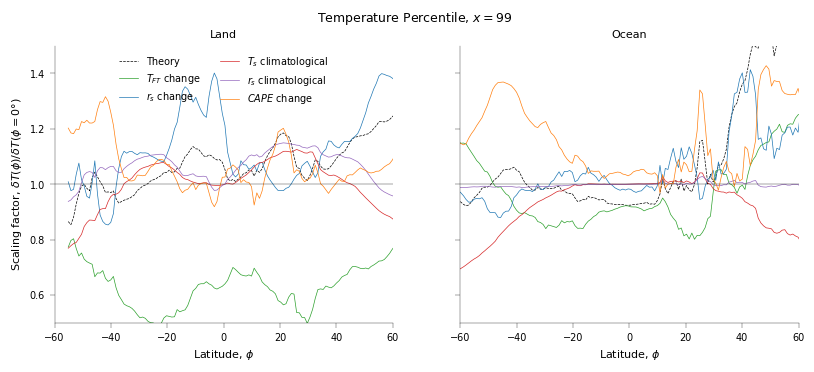

In [21]:
colors_cont = {'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0],
               'cape_change': default_colors[1]}
labels_cont = {'temp_ft_change': '$T_{FT}$ change', 'r_change': '$r_s$ change', 'cape_change': '$CAPE$ change',
               'temp_anom': '$T_s$ climatological', 'r_anom': '$r_s$ climatological'}

save_breakdown_change_fig = True
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    # ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(lat, sf_theory['linear'][i, q_plot_ind], color='k', linestyle='--', label='Theory')
    for key1 in sf_theory_breakdown:
        ax[i].plot(lat, (0 if 'ft' in key1 else 1)+sf_theory_breakdown[key1][i, q_plot_ind],
                color=colors_cont[key1], label=labels_cont[key1])
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].legend(ncol=2)
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
ax[0].set_xlim(-90, 90)
ax[0].set_xlim(-60, 60)
ax[0].set_ylim(0.5, 1.5)
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)
plt.show()
if save_fig or save_breakdown_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_breakdown_change_{q_plot}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

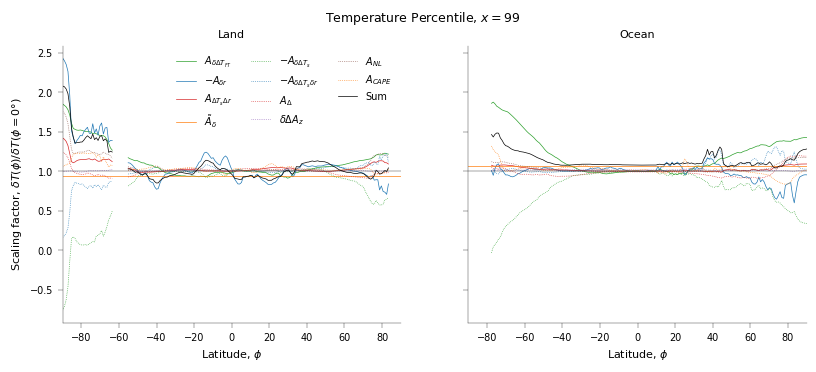

In [10]:
colors_approx = {'temp_ft_anom_change': default_colors[2], 'r_change': default_colors[0], 'anom_temp_s_r': default_colors[3],
                 'ref_change': default_colors[1],
                 'temp_s_anom_change': default_colors[2], 'temp_s_anom_r_change': default_colors[0], 'anom': default_colors[3],
                 'z_anom_change': default_colors[4], 'nl': default_colors[5], 'cape': default_colors[1]}
linestyles_approx = {'temp_ft_anom_change': None, 'r_change': None, 'anom_temp_s_r': None, 'ref_change': None,
                     'temp_s_anom_change': ':', 'temp_s_anom_r_change': ':', 'z_anom_change': ':', 'anom': ':', 'nl': ':', 'cape': ':'}
labels_approx = {'temp_ft_anom_change': '$A_{\delta \Delta T_{FT}}$', 'r_change': '$-A_{\delta r}$', 'anom_temp_s_r': '$A_{\Delta T_s \Delta r}$',
                 'ref_change': '$\\tilde{A}_{\delta}$', 'temp_s_anom_change': '$-A_{\delta \Delta T_s}$',
                 'temp_s_anom_r_change': '$-A_{\delta \Delta T_s \delta r}$', 'z_anom_change': '$\delta \Delta A_z$',
                 'anom': '$A_{\Delta}$', 'nl': '$A_{NL}$', 'cape': '$A_{CAPE}$'}
label_use = ['$A_{\delta \Delta T_{FT}}-A_{\delta r}+A_{\Delta T_s \Delta r}+\\tilde{A}_{\delta}$',
             '$A_{\delta \Delta T_s}+A_{\delta \Delta T_s \delta r}+A_{\Delta}+\\tilde{A}_{\delta}+\delta \Delta A_z+A_{NL}$']

fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    for key in colors_approx:
        ax[i].plot(lat, 1+sf_theory_approx[key][i, q_plot_ind],
                    color=colors_approx[key], label=labels_approx[key], linestyle=linestyles_approx[key])
    ax[i].plot(lat, 1+sum([sf_theory_approx[key][i, q_plot_ind] for key in sf_theory_approx]),
                    color='k', label='Sum')
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Latitude, $\phi$')
    ax[i].set_title(ds_base[0]['surface'][i].capitalize())
ax[0].legend(ncol=3)
ax[0].set_xlim(-90, 90)
ax[0].set_ylabel(f'Scaling factor, $\delta T(\phi)/\delta T(\phi={lat_ref:.0f}\degree)$')
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9)
plt.show()
isca_tools.savefig(fig)

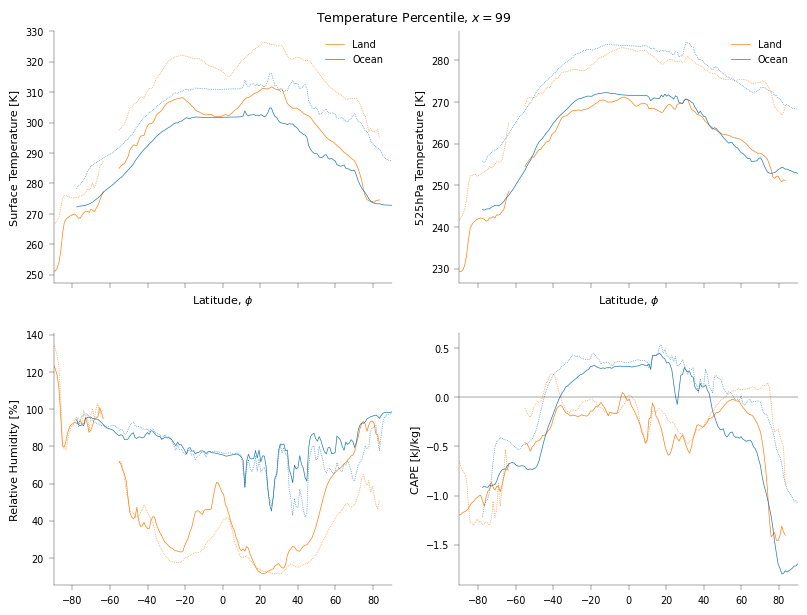

In [32]:
fig, ax = plt.subplots(2,2, sharex=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
ax = ax.flatten()
for i in range(n_surf):
    for j in range(n_exp):
        ax[0].plot(lat, ds['temp'][i, q_plot_ind, j], label=ds_base[0]['surface'][i].capitalize() if j==0 else None, color=default_colors[1-i],
                   linestyle=['-', ':'][j])
        ax[1].plot(lat, ds['temp_ft'][i, q_plot_ind, j], label=ds_base[0]['surface'][i].capitalize() if j==0 else None, color=default_colors[1-i],
                   linestyle=['-', ':'][j])
        ax[2].plot(lat, ds['rh'][i, q_plot_ind, j]*100, color=default_colors[1-i], linestyle=['-', ':'][j])
        ax[3].plot(lat, ds['cape_approx'][i, q_plot_ind, j], label=['Ref', 'Warm'][j] if i==0 else None, color=default_colors[1-i],
                   linestyle=['-', ':'][j])
ax[0].set_xlabel('Latitude, $\phi$')
ax[1].set_xlabel('Latitude, $\phi$')
ax[0].set_ylabel('Surface Temperature [K]')
ax[1].set_ylabel('{:.0f}hPa Temperature [K]'.format(pressure_ft/100))
ax[2].set_ylabel('Relative Humidity [%]')
ax[3].set_ylabel('CAPE [kJ/kg]')
ax[3].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(-90, 90)
# ax[0].set_xlim(-60, 60)
ax[0].legend()
ax[1].legend()
fig.suptitle(f'Temperature Percentile, $x={q_plot}$', fontsize=9, y=0.91);
# plt.plot(lat, ds['mse_lapse'][1, q_plot_ind, 0])
# plt.plot(ds['mse_lapse'][1, q_plot_ind, 1])